# Model 2 (complex)
The main difference between this model and the previous ones is that here we consider 2 traits: the cell size $m(t)$ and its protein content $p(t)$. We call $\underline{x}$ the vector
$$
\underline{x} = \begin{pmatrix} m\\ p\end{pmatrix} 
$$

As before, the traits evolution and the cell division are governed by $g(\underline{x})$ and $h(p)$ respectively, which are defined as 
$$
\begin{aligned}
g(\underline{x})&=\omega_1m\begin{pmatrix} 1\\ c\end{pmatrix} \\
h(p)&=
    \begin{cases}
    0   & , \, p<u \\
    \omega_2 \, \frac{p+v}{u+v} & , \, p\geq u
    \end{cases}
\end{aligned}
$$
From $g(\underline{x})$ we can notice that the cell size still grows exponentially and the protein content also follows this evolution, scaled by the factor $c$. As $c$ doesn't have a real meaning, we set it to $1$. 

Moreover, in this model the condition under which the cell can divide is that it contains a minimum amount of a specific type of protein, which we call $u$. If $p\geq u$ the cell can divide, otherwise it cannot. Unlike [model 1](model_1.ipynb), we do not have any conditions on the size of the cell for the division to take place and $h$ depens only on $p$.

The initial conditions for $m(t)$ and $p(t)$ are
$$
\begin{aligned}
    p(t=0) &= 0 \\
    m(t=0) &= m_b
\end{aligned}
$$

The division process in this model occurs in the following way
$$
\begin{pmatrix} m \\ p\end{pmatrix} \rightarrow \begin{pmatrix} \text{f}m \\ 0\end{pmatrix} + \begin{pmatrix} (1-\text{f})m \\ 0\end{pmatrix}
$$
where for now we keep $\text{f}=0.5$.

## Analytical solution of the differential equations
Similarly to the [model 1](model_1.ipynb), the result of two differential equations is:
$$
\begin{aligned}

m(t) &= m_b\, e^{\omega_1 t} \\



\ln(s(t)) &= - \left[ \dfrac{m_b}{\mu+\nu} \dfrac{\omega_2}{\omega_1} \left( e^{\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{\nu - m_b}{\mu+\nu}\, \omega_2 (t-t_0) \right] \theta   (t-t_0) \\




%s(t) &= \exp\left\{ - \left[ \dfrac{m_b}{\mu+\nu} \dfrac{\omega_2}{\omega_1} \left.         %(e^\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{\nu - m_b}{\mu+\nu}\, \omega_2 (t-t_0) %\right] \theta(t-t_0) \right\}



\end{aligned}

$$

where $t_0 \equiv \dfrac{1}{\omega_1} \ln\left(1 + \dfrac{\mu}{m_b}\right) $ is the minimum time at which the cell can divide and $\theta(\tau)$ is the Heaviside function.

**Note that in this model $t_0$ is always bigger than zero, because the argument of the logarithm is alway bigger than one. This means that, independently on the choice of parameters, each cell has a time period in which cannot divide because the protein has not reached yet the threshold value $u$**.

In [1]:
import math
import numpy as np
from scipy import stats
#import sympy as smp
from pynverse import inversefunc
import pandas as pd
# from sympy.abc import t, a, b, c, d, e
import emcee
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

In [2]:
np.random.seed(seed=123)

size = 100 # length of the time series (= number of divisions)
s_drawn = np.random.uniform(low=0, high = 1, size = size)
print('Some drawn values of s:', s_drawn[:5])

Some drawn values of s: [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


In [3]:
'''
Cell size evolution m(t)
'''
def m_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    m_ = (mb)*np.exp(omega1*t)
    return m_


'''
Protein content evolution p(t)
'''
def p_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    
    p_ = (mb)*(np.exp(omega1*t) - 1)
    return p_


'''
Hazard rate function h(t)
'''
def h(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    h_ = omega2*((p_function(t, pars) + nu)/(mu+nu)) # if p(t) ≥ mu
    h_[p_function(t, pars) < mu] = 0                 # if p(t) < mu
    
    return h_


'''
Survival function s(t) for a float t
'''
def CDF_float(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    # threshold time
    
    t0 = (1.0/omega1) * np.log(1 + (mu/mb))
    #t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])
    if t>=t0:
        ln_s_ = - ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    ((nu-mb)/(mu+nu)) * omega2 * (t-t0) )
        #ln_s_ =  ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t0)-np.exp(omega1*t)) +\
        #            ((mu-mb)/(mu+nu)) * omega2 * (t0-t) )
    else:
        ln_s_ = 0
        

    s_ = np.exp(ln_s_)

    return s_


'''
Survival function s(t) for an array t
'''
# threshold time

def CDF_arr(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    t0 = (1.0/omega1) * np.log(1 + (mu/mb))
    #t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])

    ln_s_ = - ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +((nu-mb)/(mu+nu)) * omega2 * (t-t0) )
    #ln_s_ = - ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +((mu-mb)/(mu+nu)) * omega2 * (t-t0) )
    
    
    ln_s_[t < t0] = 0                 # if p(t) < mu

    s_ = np.exp(ln_s_)

    return s_


'''
Survival function s(t)
'''
def CDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    if type(t) == np.ndarray: # array
        s_ = CDF_arr(t, pars)
    else: # float
        s_ = CDF_float(t, pars)

    return s_

In [4]:
'''
Find tau numerically
'''
def draw_tau_numerical(K, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])
    t_max = 6/omega1 # approx. 5 tau to avoid roundoff error

    tau = inversefunc(CDF, args=(pars,), y_values=K, domain=[0,t_max], open_domain=True)
    
    return tau

/root/venv/lib/python3.8/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "


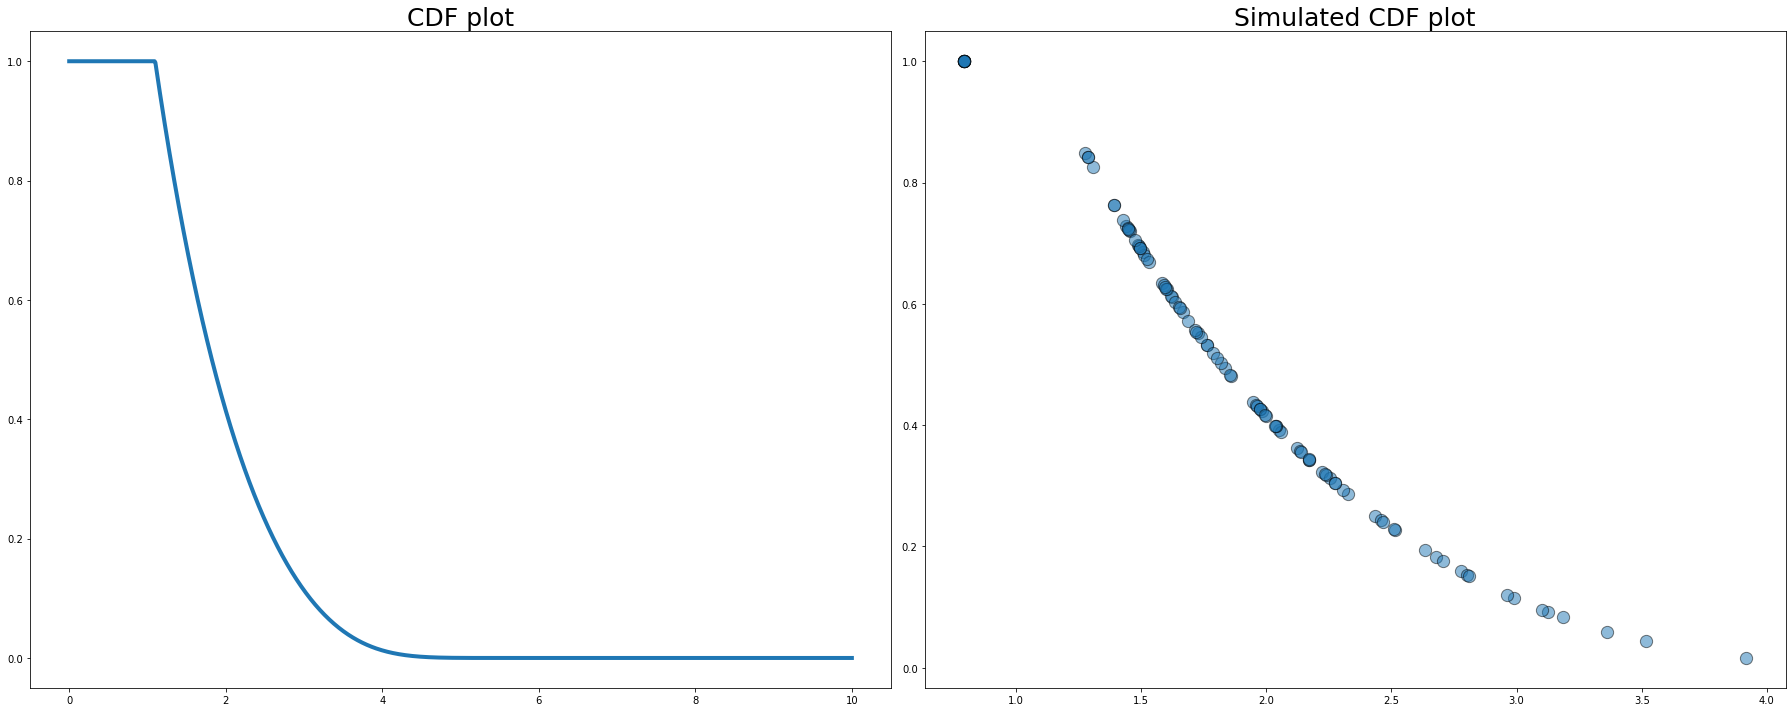

In [5]:
sim_t = draw_tau_numerical(s_drawn,(1,0.9,0.1,1,0.05))
# plot of CDF
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].plot(np.linspace(0,10,1000), CDF(np.linspace(0,10,1000),(1,0.9,0.1,1,0.05)), linewidth=4)
ax[0].set_title('CDF plot', fontsize=25)
ax[1].set_title('Simulated CDF plot', fontsize=25)
ax[1].scatter(sim_t, CDF(sim_t,(1,0.9,0.1,1,0.05)), alpha=0.5, edgecolor='black', s=150)
fig.tight_layout()

In [6]:
# numerical inversion of CDF function
#sim_t = draw_tau_numerical(s_drawn)
#df_growth = pd.DataFrame({'simulated_tau':sim_t, 's_drawn':s_drawn})

#display(df_growth)

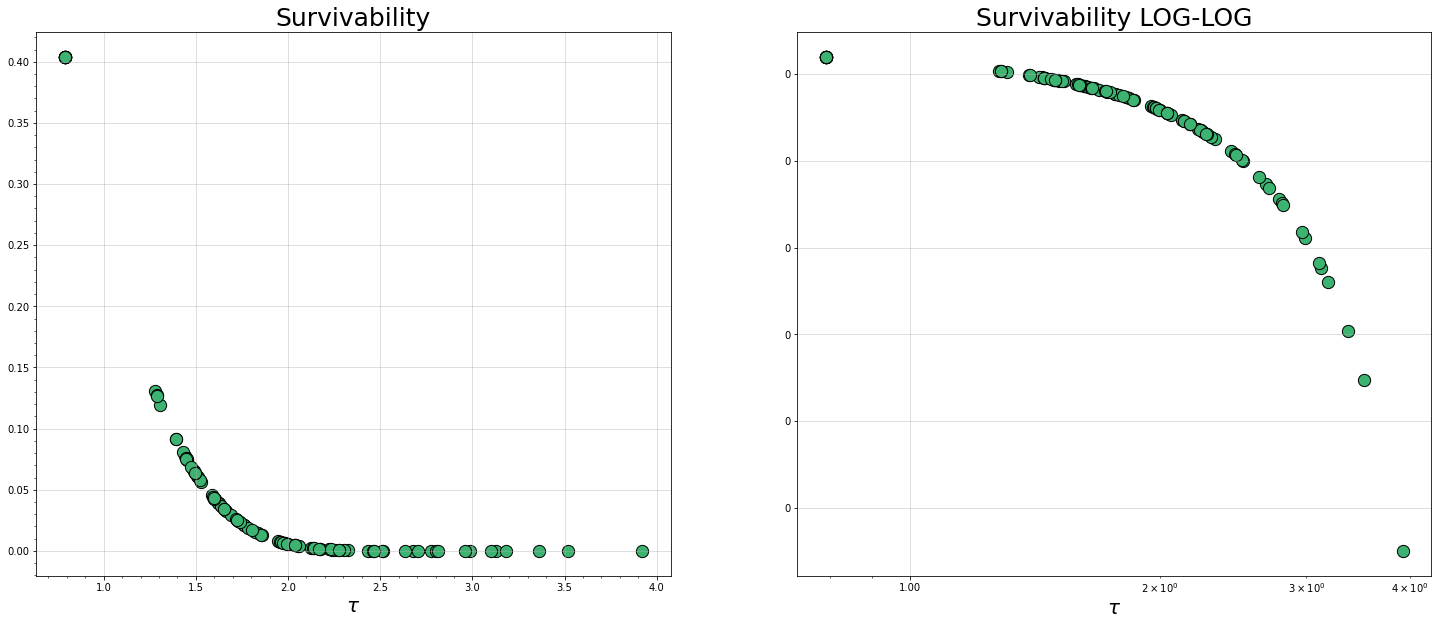

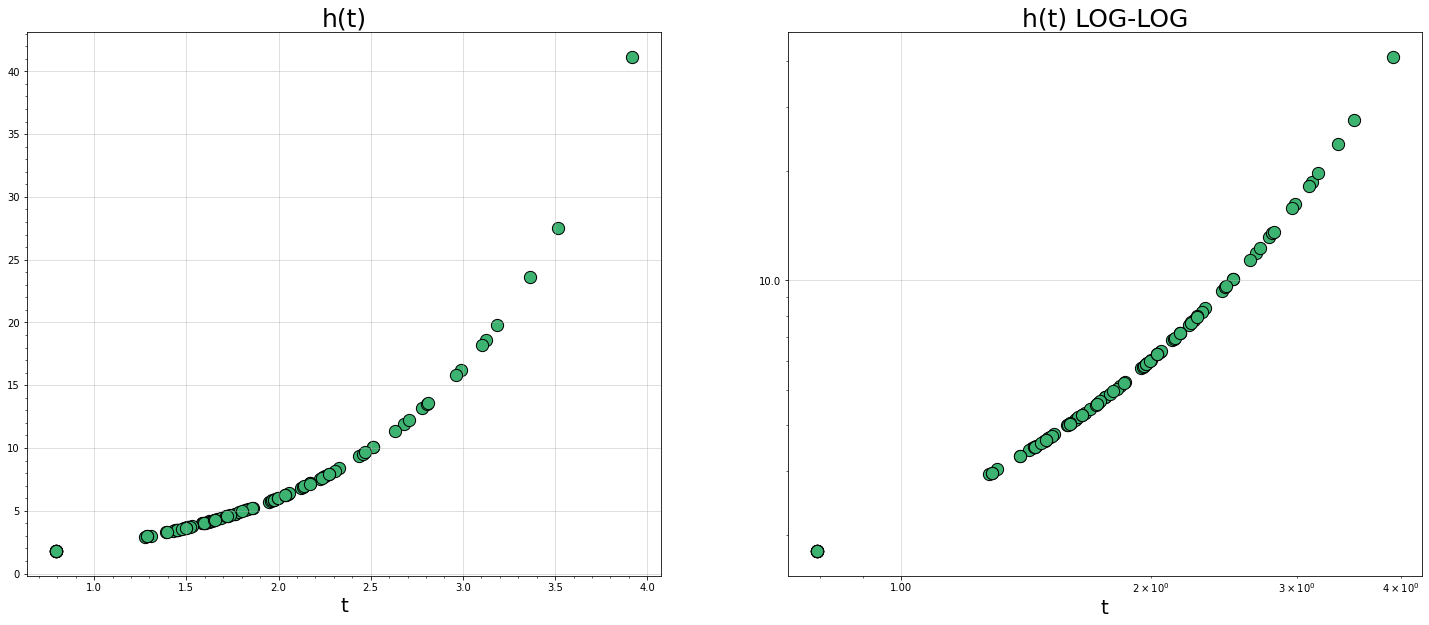

In [7]:
# PLOT s(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))

ax[0].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('Survivability', fontsize=25)
ax[0].set_xlabel('$\\tau$', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)

ax[1].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('Survivability LOG-LOG', fontsize=25)
ax[1].set_xlabel('$\\tau$', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


# PLOT h(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))

ax[0].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('h(t)', fontsize=25)
ax[0].set_xlabel('t', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)

ax[1].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('h(t) LOG-LOG', fontsize=25)
ax[1].set_xlabel('t', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

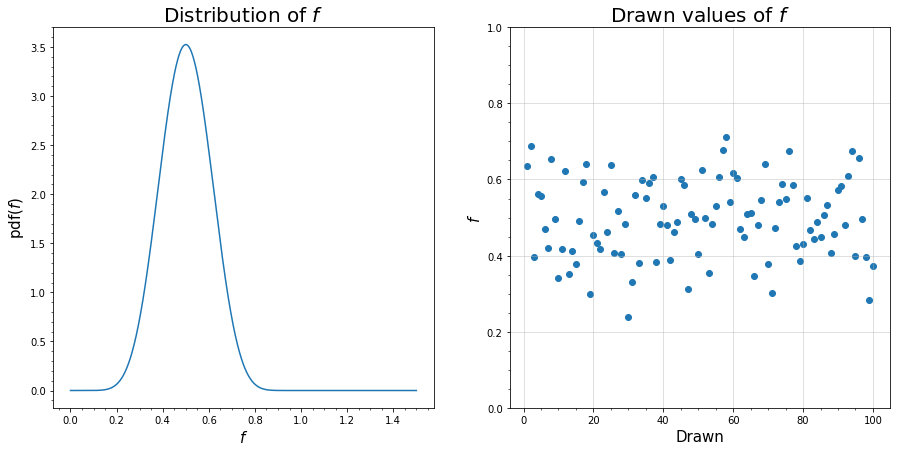

In [8]:
x = np.linspace(0, 1.5, 1000)
a=10
b=10

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(x, stats.beta.pdf(x, a=a, b=b))
ax[0].set_title("Distribution of $f$", fontsize=20)
ax[0].set_xlabel('$f$',fontsize=15)
ax[0].set_ylabel('pdf($f$)', fontsize=15)
ax[0].minorticks_on()

ax[1].scatter(range(1, size+1), np.random.beta(a=a, b=b, size=size))
ax[1].set_title("Drawn values of $f$", fontsize=20)
ax[1].set_xlabel('Drawn', fontsize=15)
ax[1].set_ylabel('$f$', fontsize=15)
ax[1].set_ylim(0, 1)
ax[1].minorticks_on()
ax[1].grid(alpha=0.5)


In [9]:
points_per_evolution=100     # number of time points between 2 divisions

t = 0
mb = 1
frac = np.random.beta(a=2, b=2, size=size)
omg_1 = np.random.gamma(shape=2, scale=1, size=size)

all_times = np.zeros(points_per_evolution*size)
cell_sizes = np.zeros(points_per_evolution*size)
sim_t = []

for i in range(size): 
    parameters = (omg_1[i],0.9,0.1,1,mb) # omega1, omega2, mu, nu, xb
    tau = draw_tau_numerical(s_drawn[i], pars=parameters)
    sim_t.append(tau)

    # evolution
    times = np.linspace(0, tau, points_per_evolution)
    mt = m_function(times, parameters)
    # pt = p_function(times, parameters)
    
    # store times and sizes
    all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
    cell_sizes[i*points_per_evolution : (i+1)*points_per_evolution] = mt

    # update the initial time and the starting size
    mb = mt[-1]*frac[i]
    t = t+tau

sim_t = np.array(sim_t)

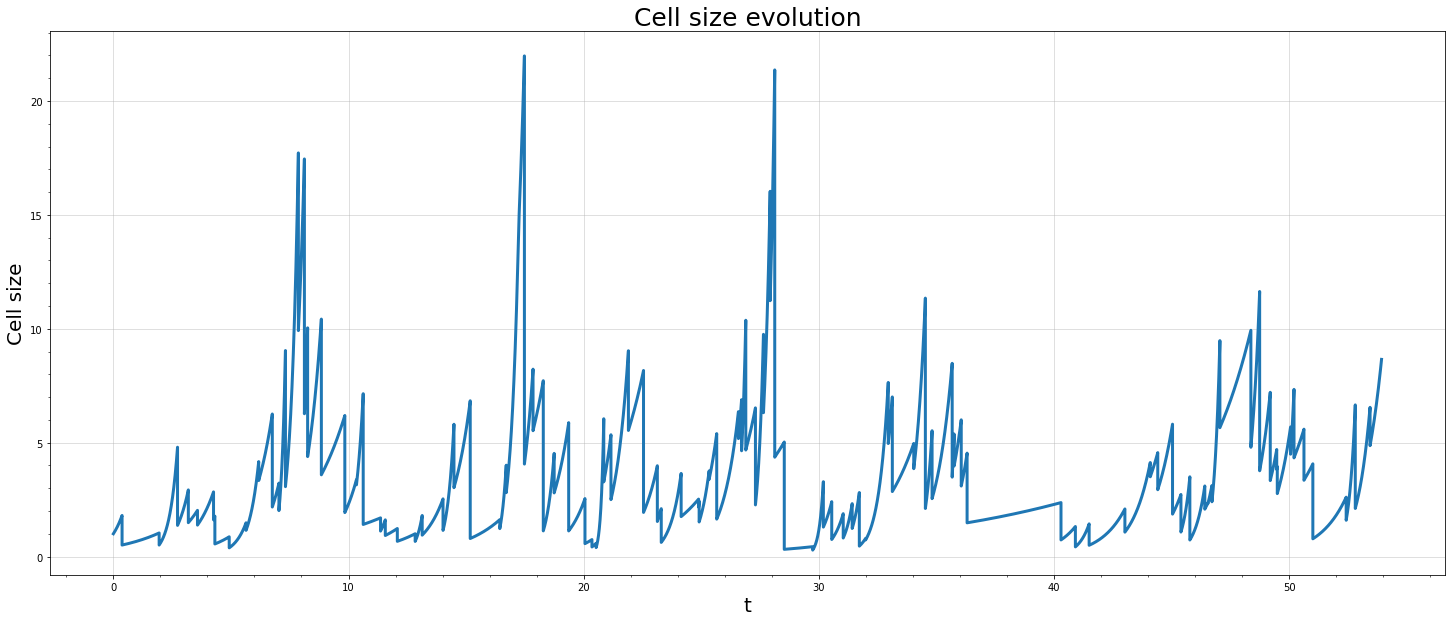

In [10]:
fig, ax = plt.subplots(1,1 , figsize=(25, 10))
ax.plot(all_times, cell_sizes, linewidth=3, color='C0')
ax.set_title('Cell size evolution', fontsize=25)
ax.set_xlabel('t', fontsize = 20)
ax.set_ylabel('Cell size', fontsize=20)
ax.minorticks_on()
ax.grid(alpha=0.5)

In [11]:
# define the distributions
def prior_omega2(omega2):
    return(stats.lognorm.pdf(omega2, s=np.sqrt(1/3 - np.log(0.9)), loc=0, scale=np.exp(1/3 )))
    #return(stats.lognorm.pdf(x, s=1/2, loc=0, scale=np.exp(np.log(0.9)+1/4)))

def prior_mu(mu):
    return(stats.beta.pdf(mu, a=2, b=5))

def prior_nu(nu):
    return(stats.lognorm.pdf(nu, s=1/3, loc=0.1, scale=np.exp(1/9)))
    
def prior_omega1(omega1):
    return(stats.lognorm.pdf(omega1, s=1/3, loc=0, scale=np.exp(1/9)))
    #return(stats.lognorm.pdf(omega1, s=1/2, loc=0, scale=np.exp(1/4)))
    

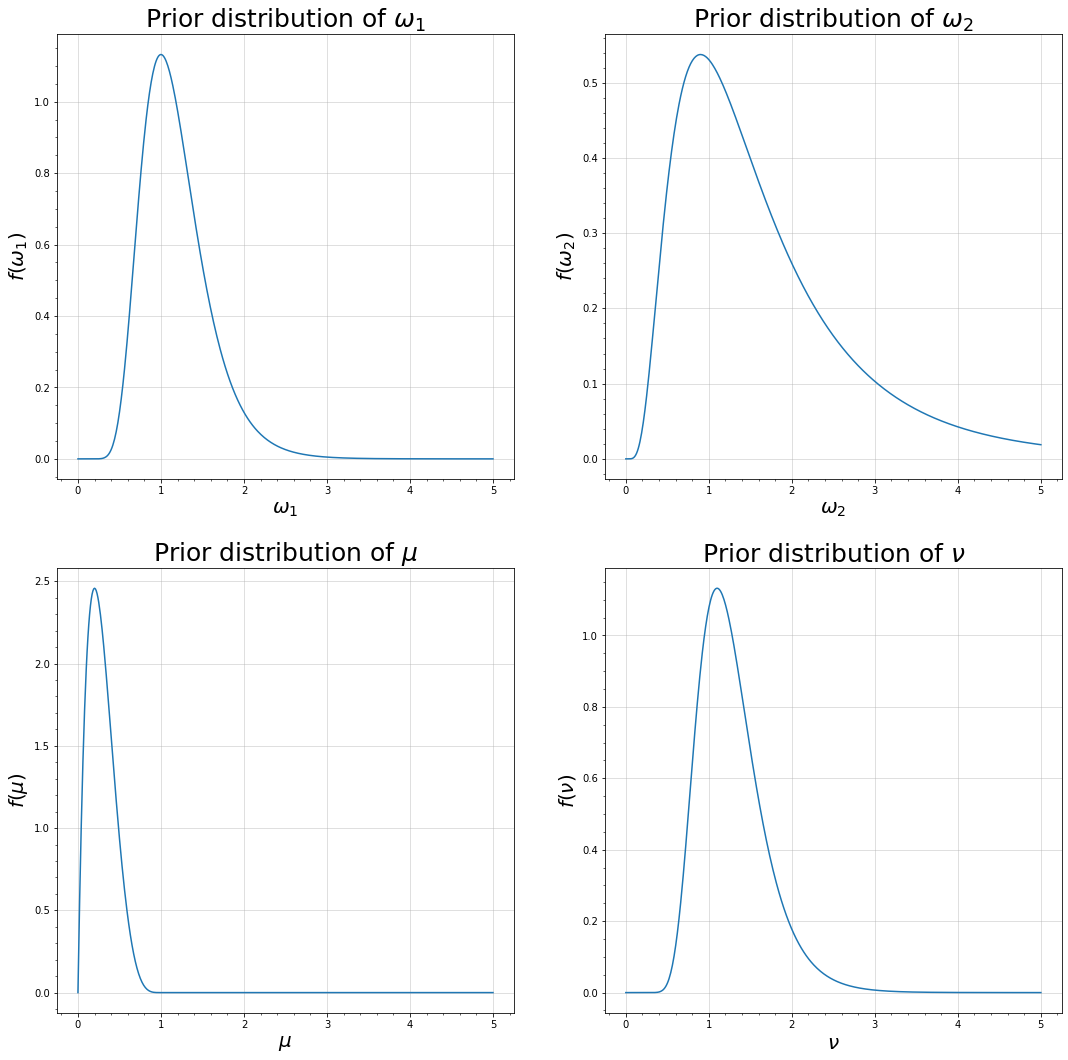

In [12]:
x = np.linspace(0, 5, 500)

_, ax = plt.subplots(2, 2, figsize=(18, 18))
ax[0, 0].plot(x, prior_omega1(x))
ax[0, 1].plot(x, prior_omega2(x)) 
ax[1, 0].plot(x, prior_mu(x)) 
ax[1, 1].plot(x, prior_nu(x))

param_str = [['$\omega_1$', '$\omega_2$'], ['$\mu$', '$\\nu$']]

for i in range(2):
    for j in range(2):
        ax[i, j].set_title('Prior distribution of ' + param_str[i][j], fontsize=25)
        ax[i, j].set_xlabel(param_str[i][j], fontsize=20)
        ax[i, j].set_ylabel('$f($'+param_str[i][j]+'$)$', fontsize=20)
        ax[i, j].minorticks_on()
        ax[i, j].grid(alpha=0.5)

## Likelihood

To retrieve the likelihood we first retrieve the pdf as minus the derivative of the cdf.
We then have that 
$$
f(y|\theta) = \prod_i f(t_i|t_{i-1,..}, \theta)
$$

In [13]:
def PDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    unnormalized = h(t, pars)*CDF(t, pars)
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])

    return(unnormalized/normalization)

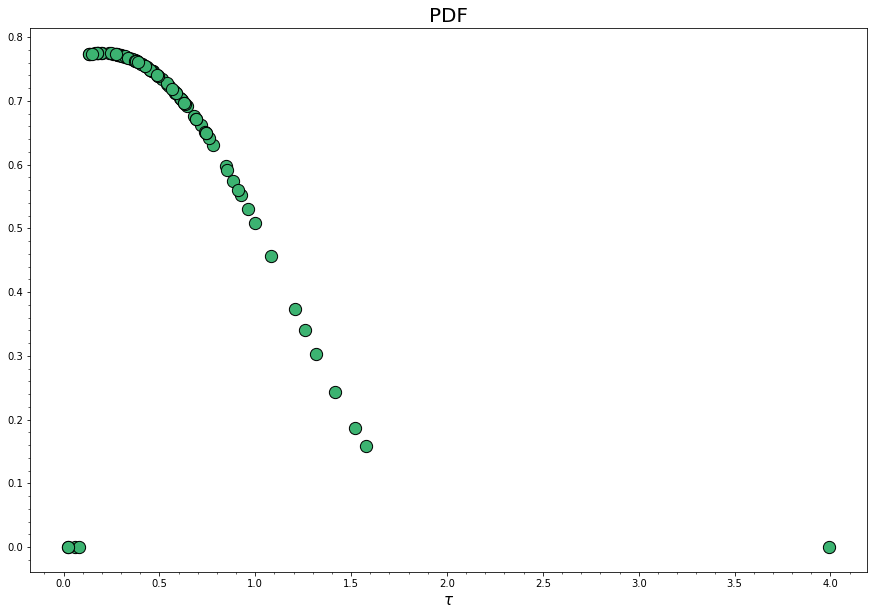

In [14]:
def likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.prod(PDF_arr(y, pars))

def log_likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.sum(np.log(PDF(y, pars)))

fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.scatter(sim_t, PDF(sim_t, pars=(1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax.set_title('PDF', fontsize=20)
ax.set_xlabel('$\\tau$', fontsize = 15)
ax.minorticks_on()

In [15]:
n_walkers = 20
ndim = 3

def j_log_unnorm_posterior_emcee(params, y_times):
    try:
        omega_1, omega_2, u, nu = np.array(params)
        
        #return(log_likelihood(y_times, pars=(1, omega_2, u, 1, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1))
    except:
        #omega_1, omega_2, u = np.array([0.00001, 0.000001, 0.00001])
        post_arr = [1, 0.9, 0.1, 1]
    
    ret = log_likelihood(y_times, pars=(omega_1, omega_2, u, nu, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu))
    
    if ret*0 ==0:
        return(ret)
    else:return(-np.inf)
    


In [16]:
p0_u = np.random.uniform(low=0.01, high=0.15, size=n_walkers).reshape(-1, 1)
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_omega_1 = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)


p0 = np.hstack([p0_omega_1, p0_omega_2, p0_u, p0_nu])

sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times':sim_t}, a=2)
'''
3   is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

samples = sampler.run_mcmc(p0, 5000)
chain = sampler.get_chain(flat=False)

'''
p0   is the initial state
5000 is the number of steps to run
'''


<ipython-input-14-3ac2ba0f1ba5>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(PDF(y, pars)))
<ipython-input-15-b22c49ec8c25>:15: RuntimeWarning: invalid value encountered in double_scalars
  if ret*0 ==0:
<ipython-input-15-b22c49ec8c25>:13: RuntimeWarning: divide by zero encountered in log
  ret = log_likelihood(y_times, pars=(omega_1, omega_2, u, nu, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu))
/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
<ipython-input-13-325457283768>:8: RuntimeWarning: invalid value encountered in true_divide
  return(unnormalized/normalization)
<ipython-input-3-0f459067baa0>:75: RuntimeWarning: overflow encountered in exp
  s_ = np.exp(ln_s_)
<ipython-input-14-3ac2ba0f1ba5>:5: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(

'\np0   is the initial state\n5000 is the number of steps to run\n'

In [17]:
# remove outliers (stucked chains) and flatten 
chain = chain[:, np.invert(np.all(chain == chain[0], axis=0))].reshape(-1, 4)


Median value of omega_1: 0.4858
Max value of omega_1: 0.4681
true value of omega_1: 1.0


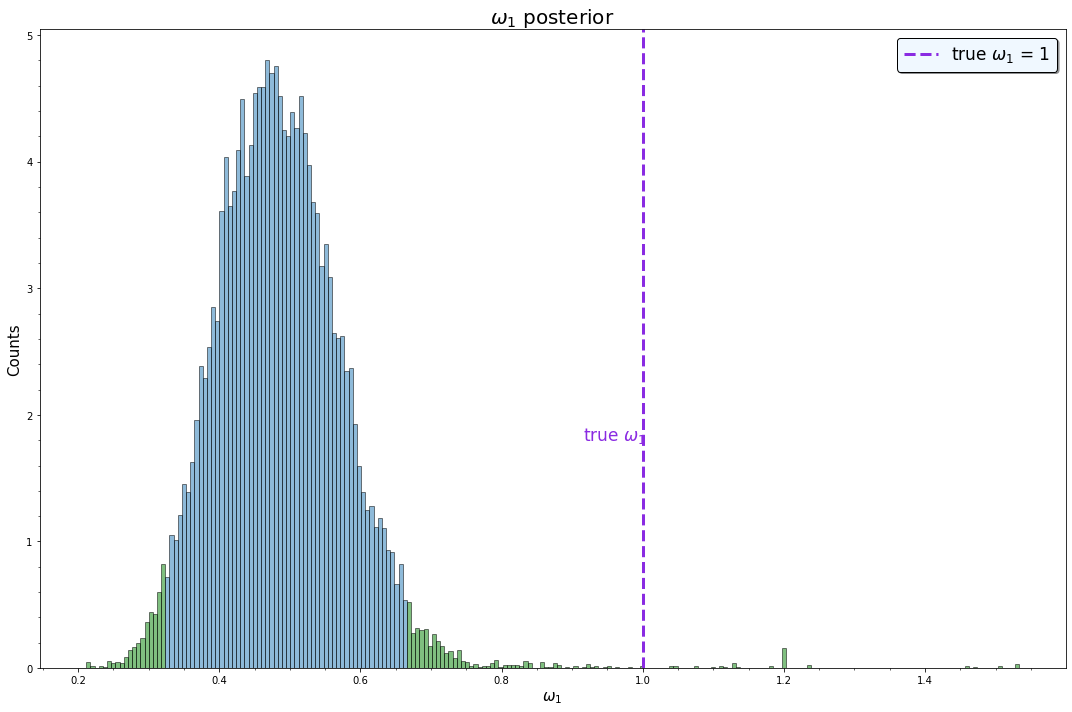

In [18]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
res_omega_1 = ax.hist(chain[:,0], bins='fd', edgecolor='black', alpha=0.5, density=True)

counts_omega_1 = res_omega_1[0]
edges_omega_1 = res_omega_1[1]
patches_omega_1 = res_omega_1[2]
tmp = np.cumsum(np.diff(edges_omega_1)*counts_omega_1)

max_index = np.argmax(counts_omega_1)
max_omega_1 = (edges_omega_1[max_index] + edges_omega_1[max_index + 1])/2
median_omega_1 = (edges_omega_1[len(tmp[tmp<0.5])+1] + edges_omega_1[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_1:', round(median_omega_1, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega_1[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega_1[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_1$', fontsize=15)
ax.set_title('$\\omega_1$ posterior', fontsize=20)
#ax.axvline(median_omega_1, color='crimson', linestyle='dashed',  linewidth=3, label='median $\omega_1$ = ' + str(round(median_omega_1, 4)))
#ax.axvline(max_omega_1, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\omega_1$ = ' + str(round(max_omega_1, 4)))
ax.axvline(1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\omega_1$ = 1')

#ax.text(median_omega_1-0.12, 1.85, 'median $\omega_1$' , color='crimson', fontsize=17)
#ax.text(max_omega_1+0.033, 1.82, 'max $\omega_1$', color='darkgreen', fontsize=17)
ax.text(1 - 0.085, 1.8, 'true $\omega_1$', color='blueviolet', fontsize=17)


print('Max value of omega_1:', round(max_omega_1, 4))
print('true value of omega_1:', 1.)

ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

fig.tight_layout()

Median value of omega_2: 1.836
Max value of omega_2: 1.8232
true value of omega_2: 0.9


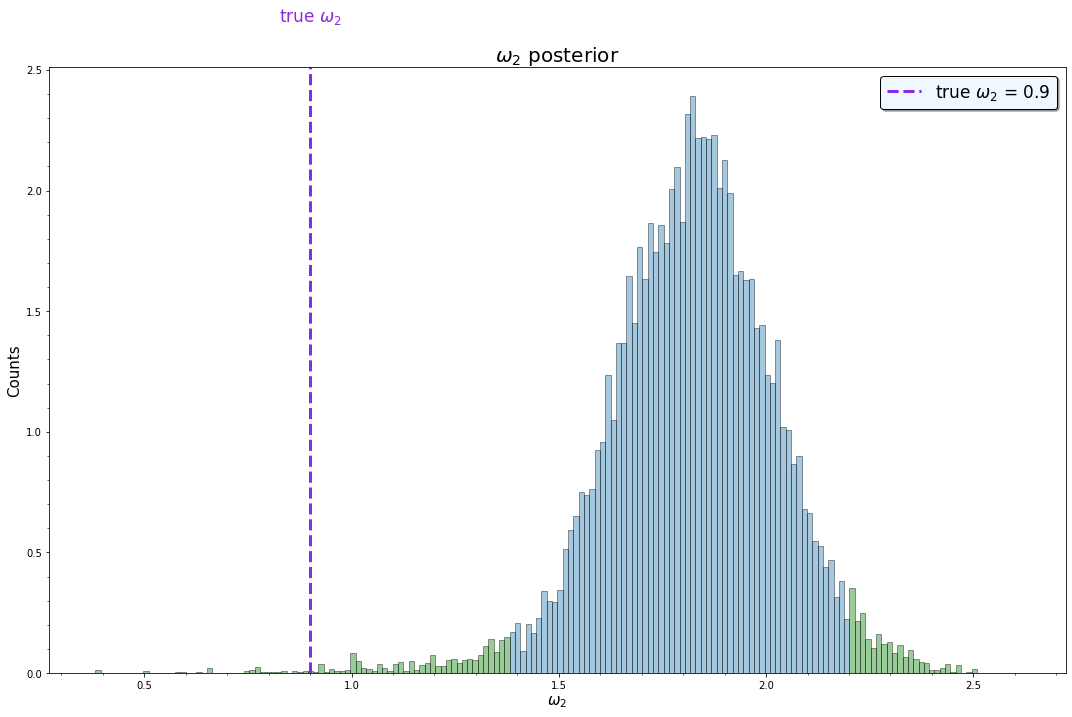

In [19]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))


res_omega_2 = ax.hist(chain[:,1], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_omega_2 = res_omega_2[0]
edges_omega_2 = res_omega_2[1]
patches_omega_2 = res_omega_2[2]
tmp = np.cumsum(np.diff(edges_omega_2)*counts_omega_2)

max_index = np.argmax(counts_omega_2)
max_omega_2 = (edges_omega_2[max_index] + edges_omega_2[max_index + 1])/2
median_omega_2 = (edges_omega_2[len(tmp[tmp<0.5])+1] + edges_omega_2[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_2:', round(median_omega_2, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega_2[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega_2[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_2$', fontsize=15)
ax.set_title('$\\omega_2$ posterior', fontsize=20)
#ax.axvline(median_omega_2, color='crimson', linestyle='dashed',  linewidth=3 , label='median $\omega_2$ = ' + str(round(median_omega_2, 4)))
#ax.axvline(max_omega_2, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\omega_2$ = ' + str(round(max_omega_2, 4)))
ax.axvline(0.9, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\omega_2$ = 0.9')

#ax.text(median_omega_2+0.012, 3.2, 'median $\omega_2$', color='crimson', fontsize=17)
#ax.text(max_omega_2-0.075, 3.3, 'max $\omega_2$', color='darkgreen', fontsize=17)

ax.text(0.9 - 0.075, 2.7, 'true $\omega_2$', color='blueviolet', fontsize=17)

ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
print('Max value of omega_2:', round(max_omega_2, 4))
print('true value of omega_2:', 0.9)


fig.tight_layout()

Median value of mu: 0.0082
Max value of mu: 0.0086
true value of mu: 0.1


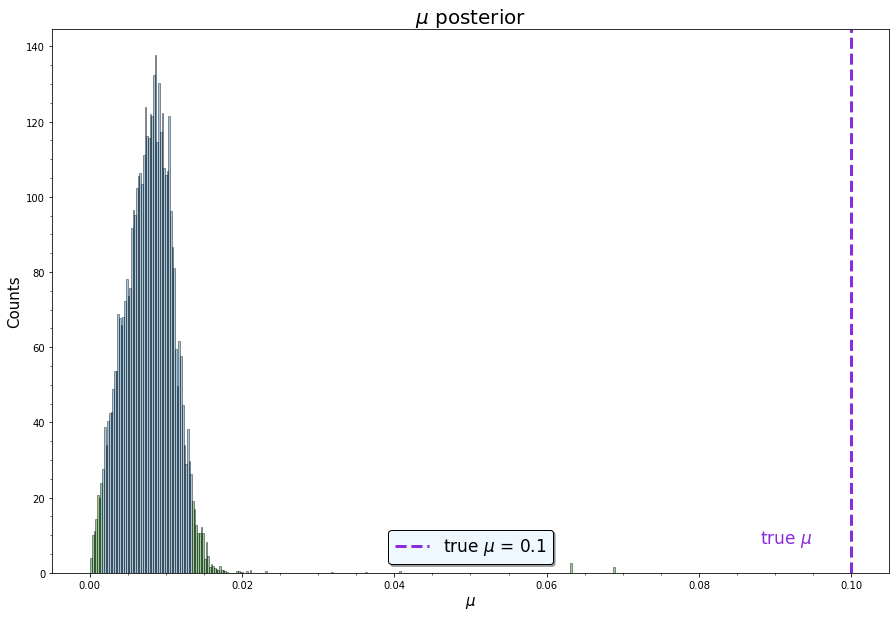

In [26]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

res_mu = ax.hist(chain[:,2], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_mu = res_mu[0]
edges_mu = res_mu[1]
patches_mu = res_mu[2]
tmp = np.cumsum(np.diff(edges_mu)*counts_mu)

max_index = np.argmax(counts_mu)
max_mu = (edges_mu[max_index] + edges_mu[max_index + 1])/2
median_mu = (edges_mu[len(tmp[tmp<0.5])+1] + edges_mu[len(tmp[tmp<0.5])+2])/2
print('Median value of mu:', round(median_mu, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_mu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_mu[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\mu$', fontsize=15)
ax.set_title('$\\mu$ posterior', fontsize=20)
#ax.axvline(median_mu, color='crimson', linestyle='dashed',  linewidth=3, label='median $\mu$ = ' + str(round(median_mu, 4)))
#ax.axvline(max_mu, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\mu$ = ' + str(round(max_mu, 4)))
ax.axvline(0.1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\mu$ = 0.1')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
#ax.text(median_mu-0.0115, 8.15, 'median $\mu$', color='firebrick', fontsize=17)
#ax.text(max_mu+0.002, 8.1, 'max $\mu$ ', color='darkgreen', fontsize=17)
ax.text(0.1-0.012, 8, 'true $\mu$', color='blueviolet', fontsize=17)
print('Max value of mu:', round(max_mu, 4))
print('true value of mu:', 0.1)


#fig.tight_layout()

Median value of nu: 1.7473
Max value of nu: 1.4774
true value of nu: 1


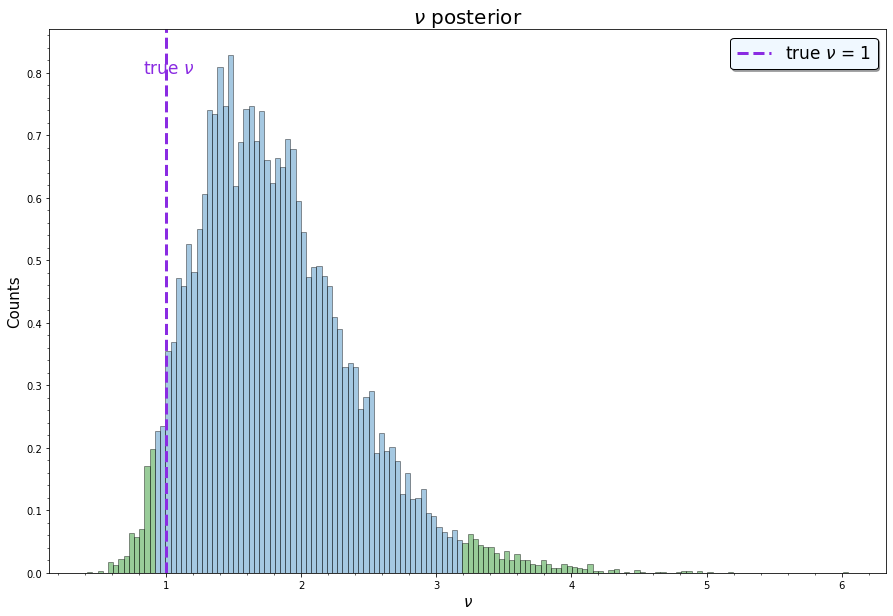

In [21]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

res_nu = ax.hist(chain[:,3], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_nu = res_nu[0]
edges_nu = res_nu[1]
patches_nu = res_nu[2]
tmp = np.cumsum(np.diff(edges_nu)*counts_nu)

max_index = np.argmax(counts_nu)
max_nu = (edges_nu[max_index] + edges_nu[max_index + 1])/2
median_nu = (edges_nu[len(tmp[tmp<0.5])+1] + edges_nu[len(tmp[tmp<0.5])+2])/2
print('Median value of nu:', round(median_nu, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_nu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_nu[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\nu$', fontsize=15)
ax.set_title('$\\nu$ posterior', fontsize=20)
#ax.axvline(median_nu, color='crimson', linestyle='dashed',  linewidth=3, label='median $\\nu$ = ' + str(round(median_nu, 4)))
#ax.axvline(max_nu, color='darkgreen', linestyle='dashed',  linewidth=4, alpha=0.6, label='max $\\nu$ = ' + str(round(max_nu, 4)))
ax.axvline(1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\\nu$ = 1')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
#ax.text(median_nu+0.03, 1.9, 'median $\\nu$', color='firebrick', fontsize=17)
#ax.text(max_nu +0.03, 1.75, 'max $\\nu$ ', color='darkgreen', fontsize=17)
ax.text(1 - 0.17, 0.8, 'true $\\nu$', color='blueviolet', fontsize=17)
print('Max value of nu:', round(max_nu, 4))
print('true value of nu:', 1)


In [22]:
chain_df = pd.DataFrame(chain, columns=['omega1', 'omega2', 'mu', 'nu'])

chain_df.head()


,omega1,omega2,mu,nu
0,0.979978,0.789210,0.056032,1.119546
1,0.936683,0.593534,0.036366,0.755361
2,0.793887,0.838932,0.010536,1.089866
3,0.607060,1.149255,0.017574,0.984044
4,1.202380,0.927542,0.068918,0.702769


/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: Th

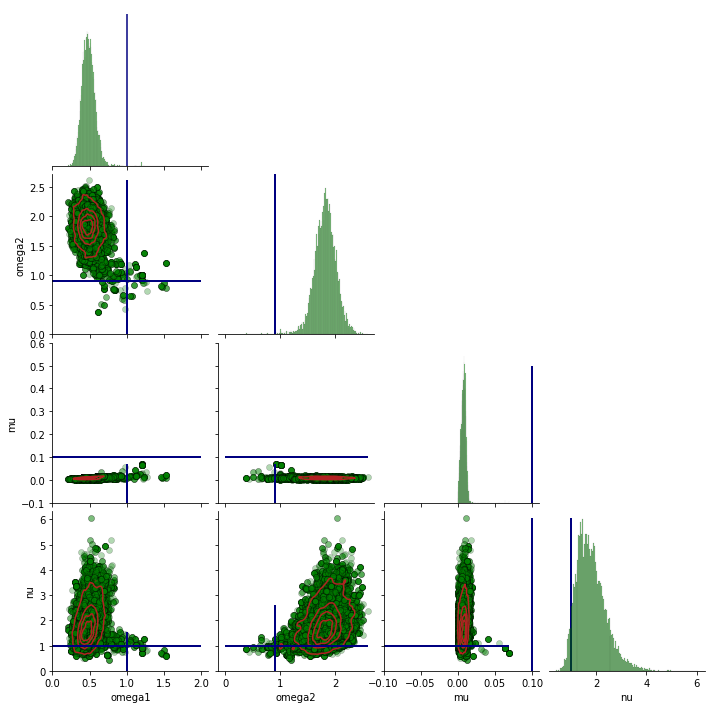

In [23]:
g = sns.pairplot(chain_df, diag_kind="hist", corner=True, plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.3}, diag_kws={'color':'green', 'alpha':0.5})
g.map_lower(sns.kdeplot, levels=5, color="firebrick", linewidth=2)
axes = g.axes.ravel()
axes_2 = []
for ax in axes:
    if ax != None:
        axes_2.append(ax)
axes_2
axes_2[0].vlines(x=1, ymin=0, ymax=1, color='navy')
axes_2[1].vlines(x=1, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[2].set_ylim(bottom=0)
axes_2[4].set_ylim(bottom=0)
axes_2[6].set_ylim(bottom=0)
axes_2[0].set_ylim(bottom=0)
axes_2[1].hlines(y=0.9, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[2].vlines(x=0.9, ymin=0, ymax=6, linewidth=2, color='navy')
axes_2[3].vlines(x=1, ymin=-0.1, ymax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[3].hlines(y=0.1, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[4].vlines(x=0.9, ymin=-0.1, ymax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[4].set_ylim(bottom=-0.1, top=0.6)
axes_2[4].hlines(y=0.1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[5].vlines(x=0.1, ymin=-0.1, ymax=0.5, linewidth=2, color='navy')
axes_2[6].vlines(x=1, ymin=0, ymax=np.max(chain[:,0]), linewidth=2, color='navy')
axes_2[6].hlines(y=1, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[6].set_xlim(left=0)
axes_2[7].vlines(x=0.9, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[7].hlines(y=1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[8].vlines(x=0.1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')
axes_2[8].hlines(y=1, xmin=-0.1, xmax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[8].set_xlim(left=-0.1)
axes_2[9].vlines(x=1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')


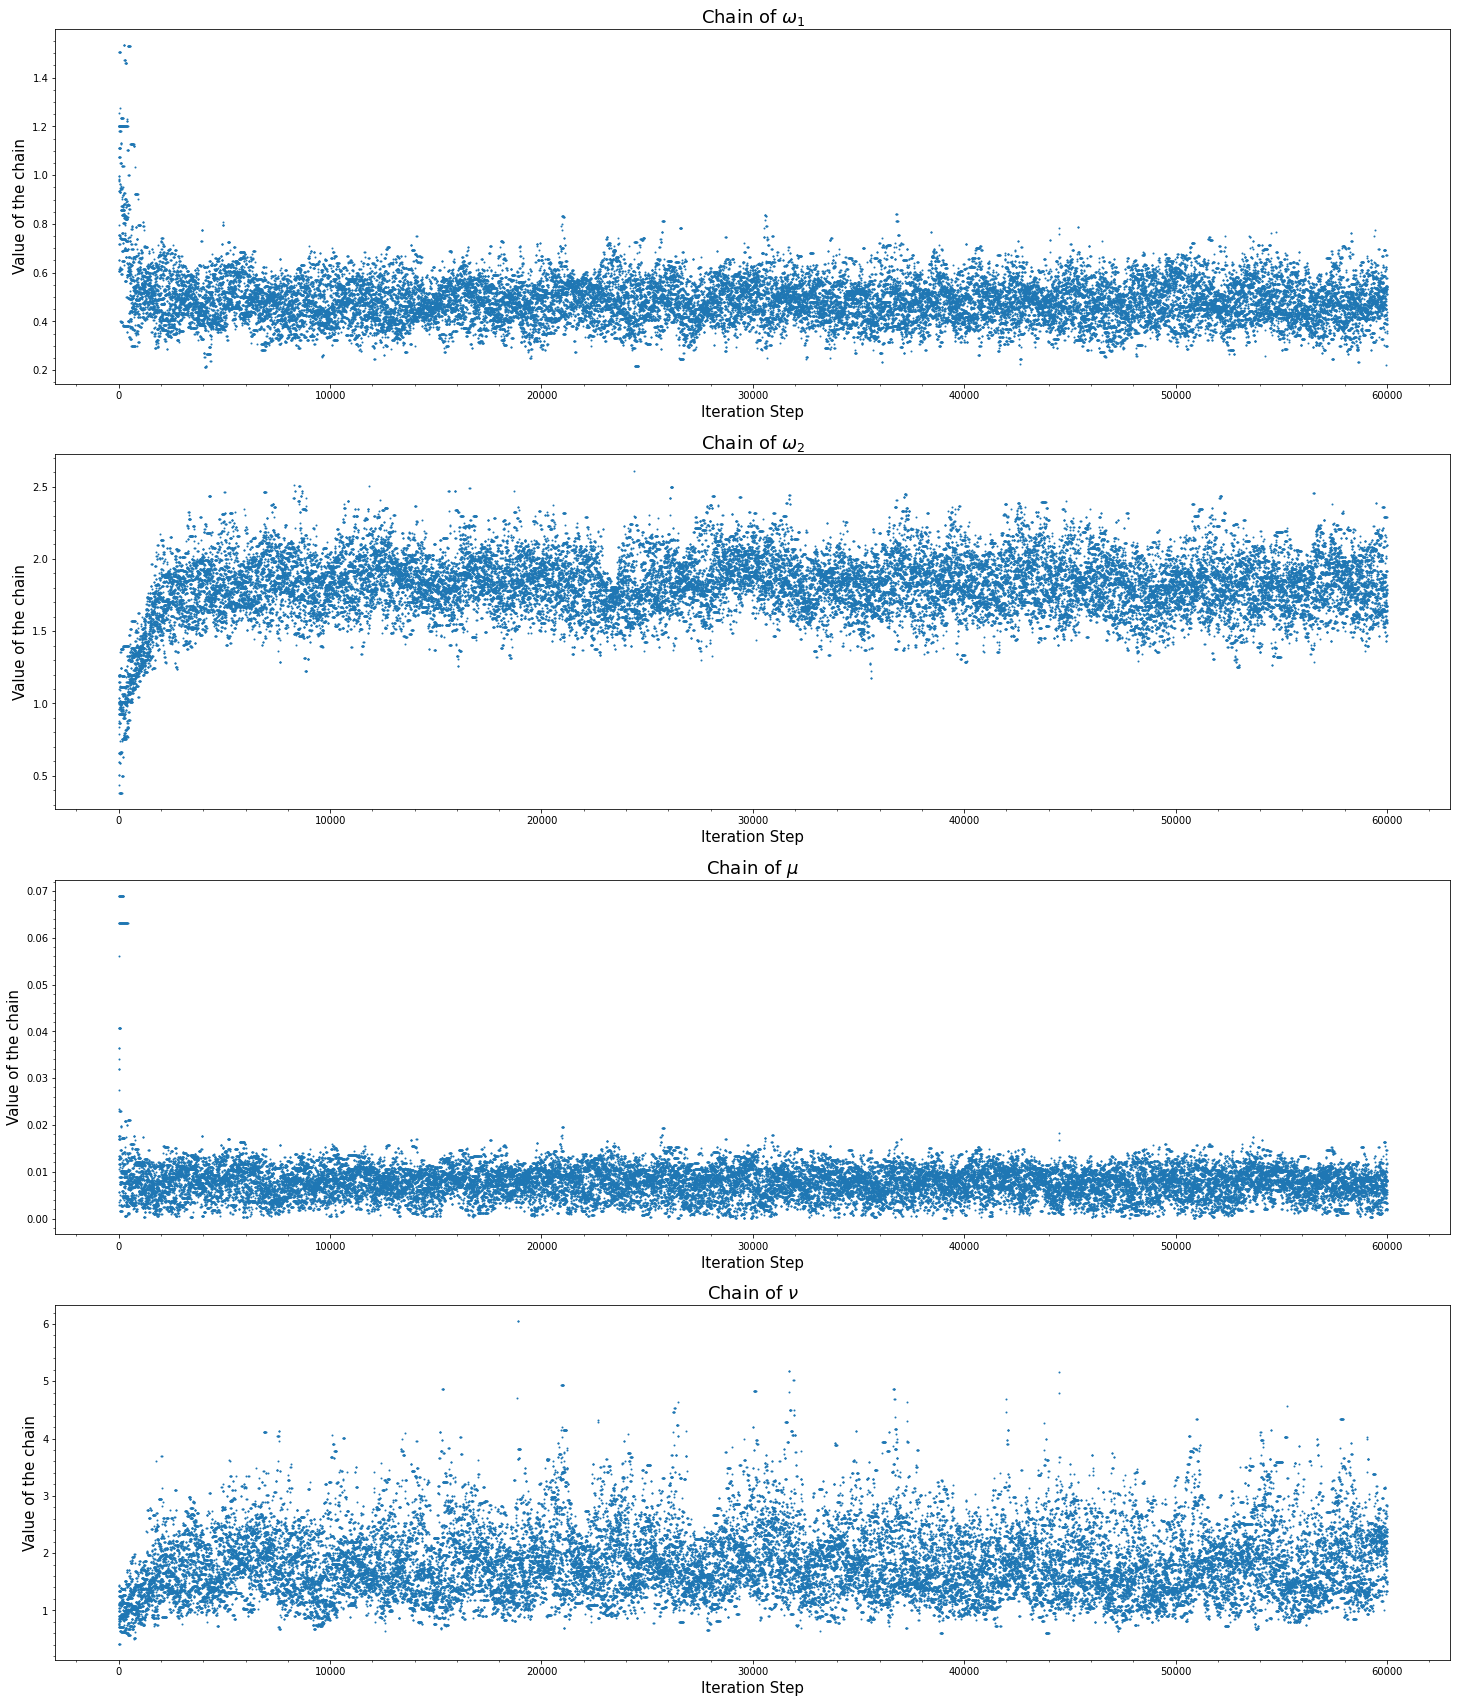

In [25]:
fig , ax = plt.subplots(4,1, figsize=(25, 30))

title_list = ['$\omega_1$', '$\omega_2$', '$\mu$', '$\\nu$']
for i, i_title in zip(range(4), title_list):
    ax[i].scatter(range(len(chain[:, i])) , chain[:,i], s=1)
    ax[i].set_ylabel('Value of the chain', fontsize=15)
    ax[i].set_xlabel('Iteration Step', fontsize=15)
    ax[i].set_title('Chain of '+i_title, fontsize=18)
    ax[i].minorticks_on()


# References
- Held J, Lorimer T, Pomati F, Stoop R, Albert C. Second-order phase transition in phytoplankton trait dynamics. _Chaos_. 2020;30(5):053109. doi:10.1063/1.5141755 
- emcee documentation: https://emcee.readthedocs.io/en/stable/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>